# Analyze A/B Test Results 

We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#Conclusion)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists.
For this project, we will be working to understand the results of an A/B test run by an e-commerce website. our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### 1- Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

**a. Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:**

In [3]:
# Reading raw data and exploring the first 5 rows:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b. Use the cell below to find the number of rows in the dataset.**

In [4]:
# Getting number of (rows, columns) in the dataset:
df.shape

(294478, 5)

**c. The number of unique users in the dataset.**

In [5]:
# Calculating the number of unique users:
df.user_id.nunique()

290584

**d. The proportion of users converted.** 

In [6]:
# The Conversion rate of both groups:
df.converted.value_counts()[1]/df.shape[0]

0.11965919355605512

**e. The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.**

In [7]:
# Calculating the wrong alignment of the treatment group:
wrong_treatment = df.query('group == "treatment" and landing_page != "new_page"')
wrong_treatment.shape[0]

1965

In [8]:
# Calculating the wrong alignment of the control group:
wrong_control = df.query('group == "control" and landing_page != "old_page"')
wrong_control.shape[0]

1928

In [9]:
# Total number of not correctly aligned group with landing page
total = wrong_treatment.shape[0] + wrong_control.shape[0]
total

3893

**f. Do any of the rows have missing values?**

In [10]:
# Calculating the number of missing values (if any):
df.isnull().sum().sum()

0

- Total number of users who are incorrectly aligned with their landing page are: 3893.
- No messing values were found in our dataset.

### 2- For the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use *Quiz 2* in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in `df2`.**

In [11]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[(df.group == "treatment") & (df.landing_page == "new_page") | (df.group == "control") & (df.landing_page == "old_page")]

In [12]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 3- Use `df2` and the cells below to answer questions for *Quiz 3* in the classroom.

**a. How many unique `user_id`s are in `df2`?**

In [13]:
# Calculating the number of unique users in the new dataframe 'df2':
df2.user_id.nunique()

290584

**b. There is one `user_id` repeated in `df2`.  What is it?**

In [14]:
# Finding the duplicated user:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c. Display the rows for the duplicate `user_id`?**

In [15]:
# Displaying all the duplicated user's rows using their ID found in 'b.':
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d. Remove one of the rows with a duplicate `user_id`, from the `df2` dataframe.**

In [16]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(1899, inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2.query('user_id == 773192')

C:\Users\Mhmdh\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### 4- Use *df2* in the cells below to answer the quiz questions related to *Quiz 4* in the classroom.

**a. What is the probability of an individual converting regardless of the page they receive?**


In [17]:
# Calculating the population conversion rate of both groups in the new dataframe:
p_population = df2.converted.value_counts()[1]/df2.shape[0]
p_population

0.11959708724499628

**b. Given that an individual was in the `control` group, what is the probability they converted?**

In [18]:
# Calculating the conversion rate for the control group:
p_control = df2.query('group == "control"')["converted"].mean()
p_control

0.1203863045004612

**c. Given that an individual was in the `treatment` group, what is the probability they converted?**

In [19]:
# Calculating the conversion rate for the treatment group:
p_treatment = df2.query('group == "treatment"')["converted"].mean()
p_treatment

0.11880806551510564

In [20]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

**d. What is the probability that an individual received the new page?**

In [21]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

**e. Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.**

- The new page didn't lead the treatment group to more conversions, the opposite actually happened and it decreased the conversion rate, but by a very small difference of **(0.00158)**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### 1- For now, consider you need to make the decision just based on all the data provided.  
**If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? You can state your hypothesis in terms of words or in terms of $p_{old}$ and $p_{new}$, which are the converted rates for the old and new pages.**

Null hypothesis:

$$H_0: p_{old} \leq p_{new}$$
<center>
or
</center>
$$H_0: P_{new} - P_{old} \leq 0$$

Alternaive hypothesis:

$$H_1: p_{new} > p_{old}$$
<center>
or
</center>
$$H_1: p_{new} - p_{old} > 0$$


### 2 - Null Hypothesis $H_0$ Testing
**Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the `converted` success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal.** <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

**Use the cells below to provide the necessary parts of this simulation.  You can use *Quiz 5* in the classroom to make sure you are on the right track.**

**a. What is the `conversion rate` for $p_{new}$ under the null hypothesis?** 

In [22]:
# Calculatin the conversion rate under the null hypothysis:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b. What is the "conversion rate" for $p_{old}$ under the null hypothesis?** 

In [23]:
# Calculatin the conversion rate under the null hypothysis:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c. What is $n_{new}$, the number of individuals in the treatment group?**

In [24]:
# Calculating the number of users in the treatment group:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

**d. What is $n_{old}$, the number of individuals in the control group?**

In [25]:
# Calculating the number of users in the control group:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [26]:
# Simulate a Sample for the treatment Group:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, 1-p_new], replace=True)
new_page_converted.mean()

0.11937925813777442

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [27]:
# Simulate a Sample for the control Group:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, 1-p_old], replace=True)
old_page_converted.mean()

0.11965664881534205

**g. Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above.**

In [28]:
# Calculating the difference between the new and the old conversion rate after sampling:
new_page_converted.mean() - old_page_converted.mean()

-0.00027739067756762936


**h. Sampling distribution**

Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [31]:
# Sampling distribution 
p_diffs = []
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs.append(new_page_converted - old_page_converted)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>


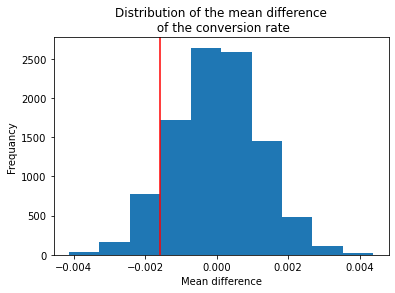

In [32]:
# Plotting a Histogram using Matplotlib library
plt.hist(p_diffs)
plt.axvline(obs_diff, color="red")
plt.title("Distribution of the mean difference\n of the conversion rate")
plt.xlabel("Mean difference")
plt.ylabel("Frequancy");

In [33]:
# Creating a numpy array of the mean difference
p_diffs = np.array(p_diffs)

**j. What proportion of the `p_diffs` are greater than the actual difference observed in the `df2` data?**

In [55]:
# Calculating the Low and High probability to calculate the P-Value:
p_value = (p_diffs > obs_diff).mean()
p_value

0.9012

**k. Please explain in words what you have just computed in part `j.`above.**
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

The value we calculated is the P-value, which is the probabilty of observing our statistics (or more extreme results) if the Null hypothesis is true.

The result of our calculation of the P-value is "0.9", which is greater than the Type I error rate "0.05". With that being said, we don't have evidence to reject the Null hypothesis "$H_0: p_{old} \leq p_{new}$"



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [35]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]


# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').shape[0]

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').shape[0]

**m. Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.**

In [52]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(f"Z-score: {z_score}\nP-value: {p_value}")

Z-score: -1.3109241984234394
P-value: 0.9050583127590245


**n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts `j.` and `k.`?**

A z-score measures the distance between a data point and the mean using standard deviations, The z-score and p-value we computed agree with the findings in previous findings with P-value of 0.9 which is greater than the alpha level of 0.05.

So again we failed to reject the null hypothesis "$H_0: p_{old} \leq p_{new}$".

<a id='regression'></a>
### Part III - A regression approach

### 1- In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.


**a. Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?**

A Logistic Regression model is the appropriate type to use.

**b. The goal is to use `statsmodels` library to fit the regression model you specified in part `a.` above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:**
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [39]:
# creating the intercept column and the dummy column for the treatment group:
# Treatment group dummy value = 1, Control group dummy value = 0.
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

C:\Users\Mhmdh\AppData\Local\Temp/ipykernel_3792/3952000736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1
C:\Users\Mhmdh\AppData\Local\Temp/ipykernel_3792/3952000736.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']


**c. Use `statsmodels` to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts.**


In [41]:
# Initializing and fitting the model:
logit_mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d. Provide the summary of your model below, and use it as necessary to answer the following questions.**

In [42]:
# The model summary:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-12-19 15:16 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e. What is the p-value associated with `ab_page`? Why does it differ from the value you found in `Part II`?**

The p-value associated with ab_page is (0.1899). And it is different because our logistic regression model is two-tailed test with null hypothesis "$H_0: p_{old} = p_{new}$" and the alternative hypothesis "$H_0: p_{old} \neq p_{new}$", but in our previous findings we performed one-tailed tests.

**f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?**

So far it appears that neither the old or the new landing page really affect the user conversion, so adding more related features may help finding pattern in our data to find the reason that affect the conversion rate.

But we should make sure that the related features we added are correlated to the response variable not with each others or it will cause a **multicolinearity**.

**g. Adding countries: Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.**

In [56]:
# Read the countries.csv & joining with the df2 dataframe
df_merged = pd.read_csv('countries.csv').set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [57]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged.country)

In [58]:
# exploring the first 5 rows:
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 

In [59]:
# Initializing and fitting the model:
logit_mod = sm.Logit(df_merged.converted, df_merged[['intercept', 'ab_page', 'US', 'UK']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [60]:
# The model summary:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-12-19 16:40 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

- The P-value for both US and UK are still greater than 0.05, so we still fail to reject the null hypothesis.

In [61]:
# Adding the necessary extra columns of the interaction between page and country:
df_merged['US_ab_page'] = df_merged.US * df_merged.ab_page
df_merged['UK_ab_page'] = df_merged.UK * df_merged.ab_page
df_merged['CA_ab_page'] = df_merged.CA * df_merged.ab_page

In [62]:
# exploring the first 5 rows:
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,US_ab_page,UK_ab_page,CA_ab_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [63]:
# Initializing and fitting the model:
logit_mod = sm.Logit(df_merged.converted, df_merged[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [64]:
# The model summary:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-12-19 16:40 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

After creating our model the calculated P-value for both the US users and the UK users who got the new page and represented as higher order terms and the other lower order terms, they all have a P-value greater than the alpha level of 0.05, which mean this interaction does not have a significant impact on the conversion rates.

We still fail to reject the null hypothesis "$H_0: p_{old} = p_{new}$" in this test too.

<a id='Conclusion'></a>
## Conclusion

In conclusion and based on the evidence we obtained from our tests that the P-value is greater than alpha level of 0.05, we failed to reject the null hypothesis in all of our tests that we performed.

1- We may consider other factors that may have affected our A/B test such as:
- Novelty effect and/or change aversion which produce bias results.
- Change in user's behavior based on time or seasonal events.

Running the test long enough might help elimanating these factors

2- Considering the practical significance of the change in landing page (The cost vs the revenue of launching the new page)